## An치lisis

En este notebook vamos a hacer un an치lisis de las distintas competiciones (las cinco grandes ligas durante la temporada 2015-2016) y de todos los partidos en general para poder entender que caracter칤sticas son m치s importantes a la hora de tomar la decisi칩n por parte del modelo de ML para decidir si el equipo va a ganar, perder o empatar el partido.

In [8]:
import shap
import pandas as pd
import numpy as np

### La Liga temporada 2015/2016 (masculina)

Cargamos los datos de los partidos sobre La Liga en la temporada 2015/2016 masculina para entrenar el modelo y poder hacer el estudio de explicabilidad.

In [9]:
import os


competition_name = "La Liga"
competition_gender = "male"
season_name_for_filename = "2015_2016"

output_dir = "data/reduced/"
filename = f"{competition_name}({season_name_for_filename}_{competition_gender})_reduced.csv"
output_path = os.path.join(output_dir, filename)

if os.path.exists(output_path):
    print(f"Matches from the competition loaded from {output_path}")
    matches_in_LaLiga = pd.read_csv(output_path)
else:
    print("You don't have data from the competition yet. Please run the notebook '0_datasets_building.ipynb' first.")

Matches from the competition loaded from data/reduced/La Liga(2015_2016_male)_reduced.csv


In [10]:
matches_in_LaLiga.head(5)

shots_on_target_ratio_home  shots_on_target_ratio_away  \
0                    0.400000                    0.153846   
1                    0.312500                    0.300000   
2                    0.333333                    0.400000   
3                    0.461538                    0.400000   
4                    0.153846                    0.200000   

   average_shots_on_target_distance_home  \
0                              20.462904   
1                              25.239973   
2                              33.431447   
3                              24.394269   
4                              20.432657   

   average_shots_on_target_distance_away  shots_inside_area_ratio_home  \
0                              15.923442                      0.600000   
1                              18.652679                      0.187500   
2                              11.773407                      0.500000   
3                               9.439840                      0.538462   
4                              19.849825                      0.384615   

   shots_inside_area_ratio_away  pass_success_ratio_home  \
0                      0.384615                 0.630915   
1                      0.600000                 0.759191   
2                      0.700000                 0.609065   
3                      0.800000                 0.760377   
4                      0.800000                 0.775176   

   pass_success_ratio_away  cross_success_ratio_home  \
0                 0.804089                  0.000000   
1                 0.690647                  0.285714   
2                 0.809783                  0.125000   
3                 0.676543                  0.125000   
4                 0.700581                  0.416667   

   cross_success_ratio_away  ...  percentage_shots_under_pressure_home  \
0                  0.000000  ...                              0.500000   
1                  0.263158  ...                              0.666667   
2                  0.222222  ...                              0.166667   
3                  0.285714  ...                              0.500000   
4                  0.272727  ...                              0.500000   

   percentage_shots_inside_area_under_pressure_home  \
0                                          1.000000   
1                                          0.000000   
2                                          0.250000   
3                                          0.666667   
4                                          0.000000   

   percentage_passes_under_pressure_home  \
0                               0.364780   
1                               0.476190   
2                               0.196491   
3                               0.582857   
4                               0.555556   

   percentage_passes_inside_area_under_pressure_home  \
0                                           0.000000   
1                                           0.333333   
2                                           0.400000   
3                                           1.000000   
4                                           0.750000   

   percentage_set_piece_shots_home  \
0                         0.214286   
1                         0.470588   
2                         0.333333   
3                         0.600000   
4                         0.615385   

   percentage_set_piece_shots_inside_area_home  percentage_substitutions_home  \
0                                     0.285714                            0.5   
1                                     0.000000                            0.5   
2                                     0.250000                            0.5   
3                                     0.444444                            0.5   
4                                     0.384615                            0.5   

   percentage_tactical_substitutions_home  percentage_tactical_changes_home  \
0                                    0.40              

Una vez ya tenemos los datos cargados, entrenamos el mejor modelo y mostramos sus resultados.

In [11]:
from src.analysis import laliga_best_model


best_model_LaLiga, evaluation_metrics, X_train_reduced_LaLiga, X_test_reduced_LaLiga, feature_names_reduced_LaLiga, encoder_LaLiga = laliga_best_model(matches_in_LaLiga)
print(f"The best model for La Liga is {best_model_LaLiga}")
print(f"The evaluation metrics for the best model are:")
evaluation_metrics.head()

The best model for La Liga is LogisticRegression(C=0.29354310869235306, max_iter=1000, penalty='l1',
                   random_state=42, solver='saga')
The evaluation metrics for the best model are:


Train Accuracy  Test Accuracy  Precision Macro  \
Logistic Regression MI        0.766447       0.723684         0.702033   

                        Precision Weighted  Recall Macro  Recall Weighted  \
Logistic Regression MI            0.717442      0.684041         0.723684   

                        F1 Macro  F1 Weighted  
Logistic Regression MI  0.690678     0.718346

Una vez ya tenemos el mejor modelo entrenado comenzamos el an치lisis de explicabilidad. Vamos a comenzar por un estudio global. 

En este caso, al ser el mejor modelo Logistic Regression, vamos a fijarnos en el coeficiente (m칠todo coef_) que nos aporta el modelo para cada caracter칤stica en cada clase. 
- Con esto, estamos observando la importancia global de cada caracter칤stica para cada clase en t칠rminos de una relaci칩n lineal. Es decir, estamos observando relaciones exclusivamente lineales entre las caracter칤sticas y la predicci칩n.
- Con esto, no se tiene en cuenta las interacciones entre caracter칤sticas ni tampoco explica predicciones individuales.

Los gr치ficos que se aparecen a continuaci칩n muestran la importancia de cada caracter칤stica para predecir una determinada clase de resultado en los partidos de LaLiga. Las clases son:
- Clase "away_team": Indica qu칠 caracter칤sticas influyen en que el equipo visitante gane el partido.
- Clase "draw": Indica qu칠 caracter칤sticas influyen en que el partido termine en empate.
- Clase "home_team": Indica qu칠 caracter칤sticas influyen en que el equipo local gane el partido.
Los valores representados en el eje X son los coeficientes de la regresi칩n log칤stica, que indican la magnitud e impacto de cada variable en la probabilidad de un resultado espec칤fico. Valores positivos aumentan la probabilidad de que ocurra esa clase, mientras que valores negativos disminuyen dicha probabilidad.

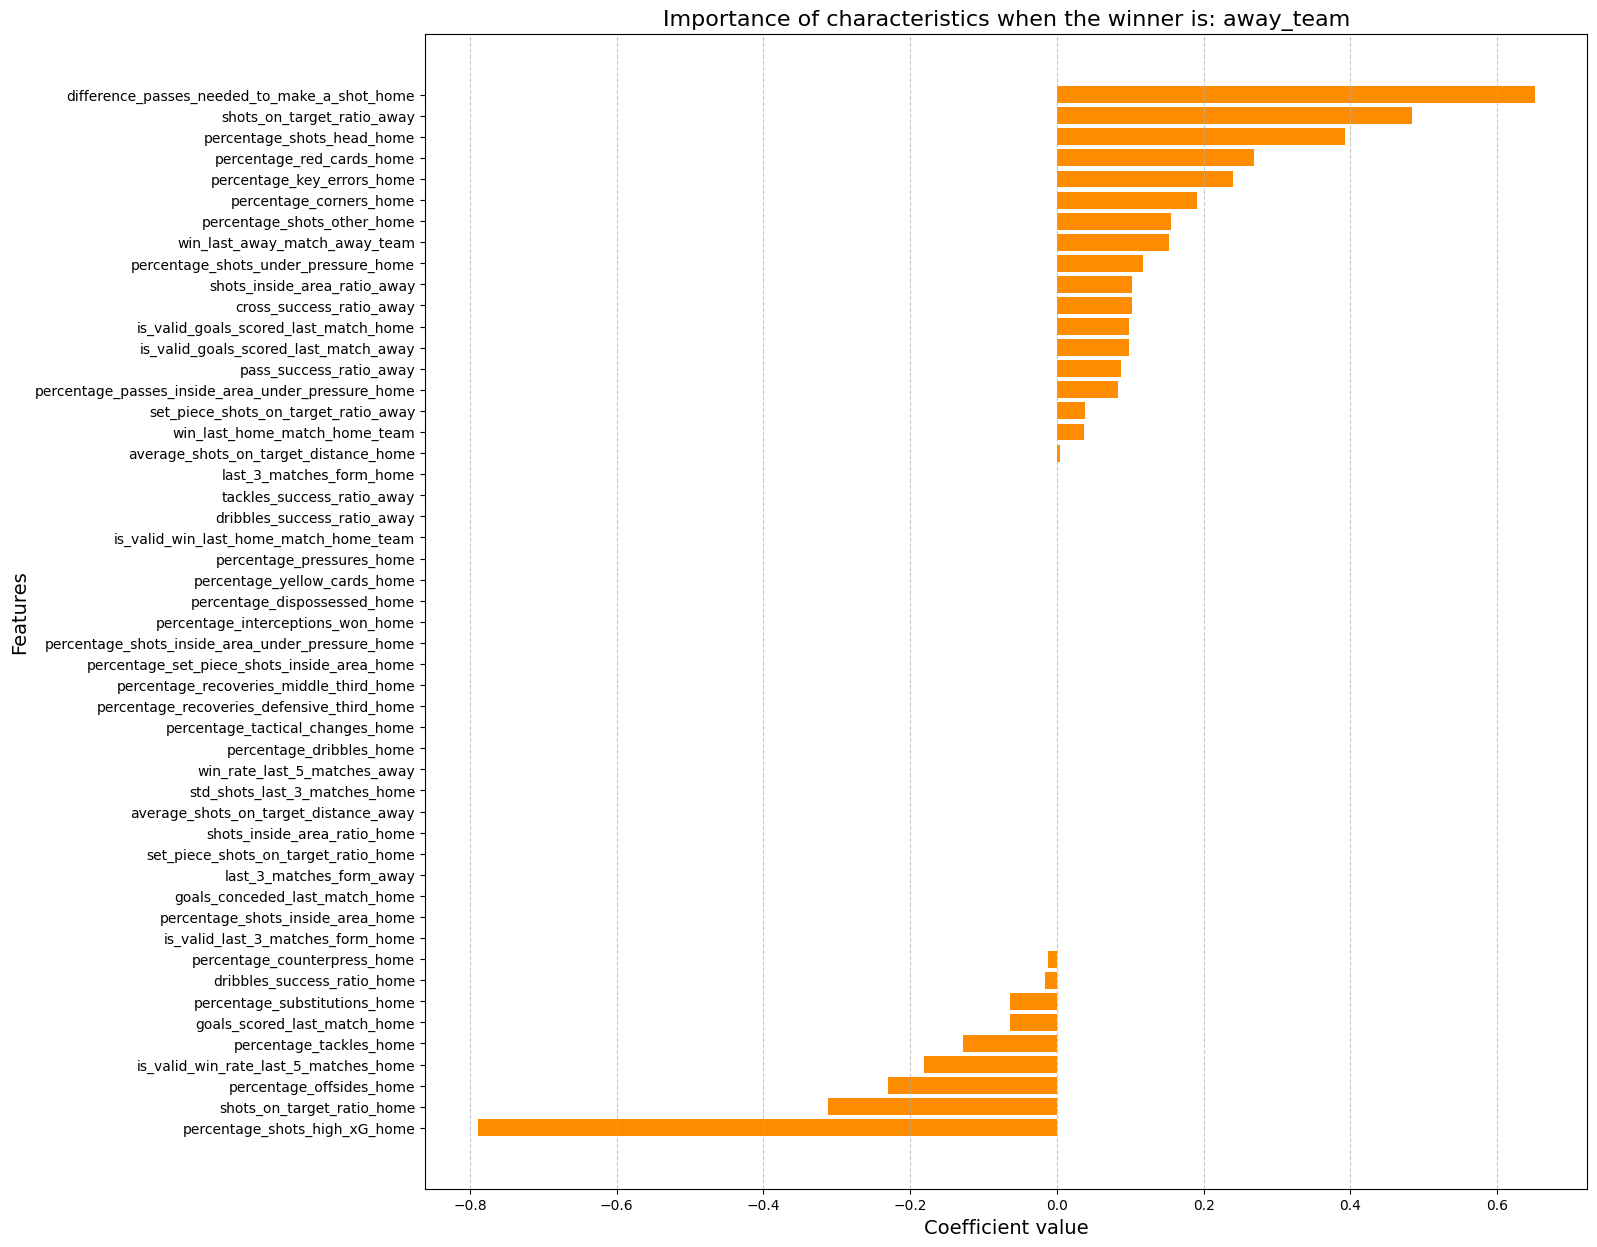

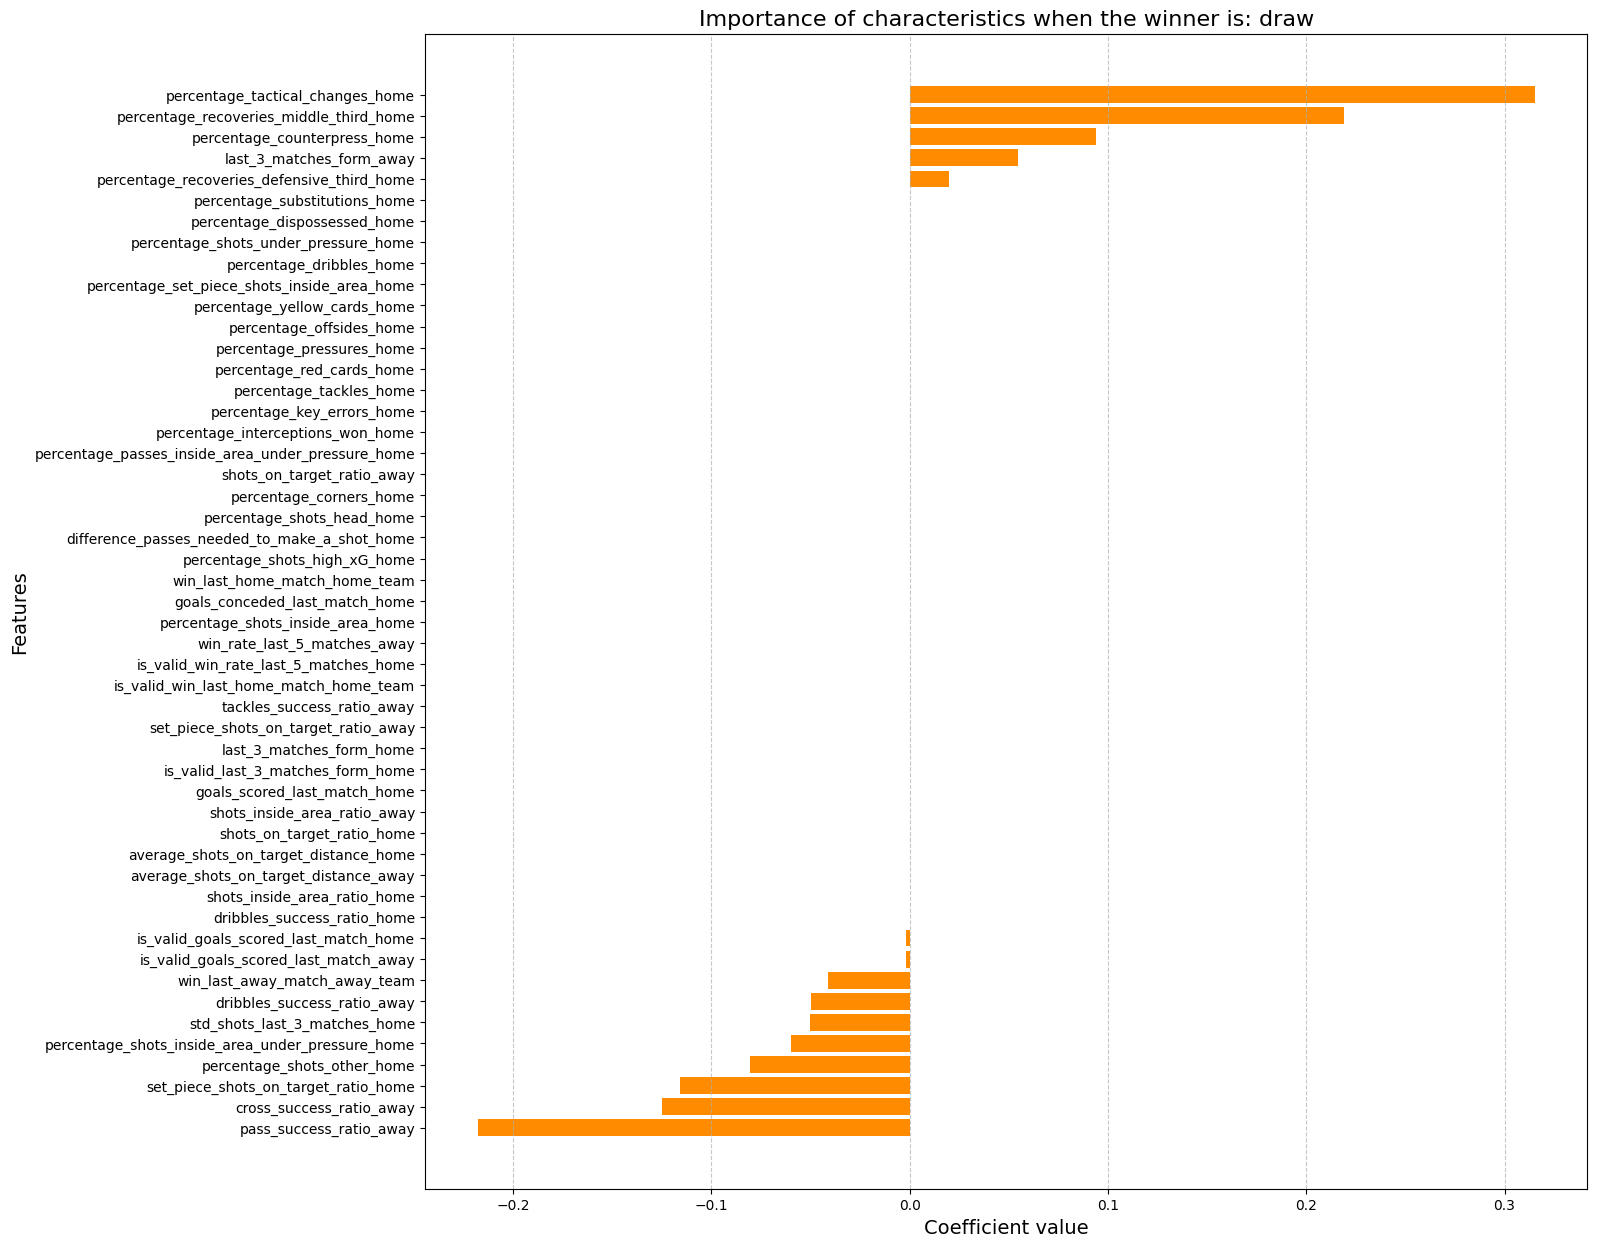

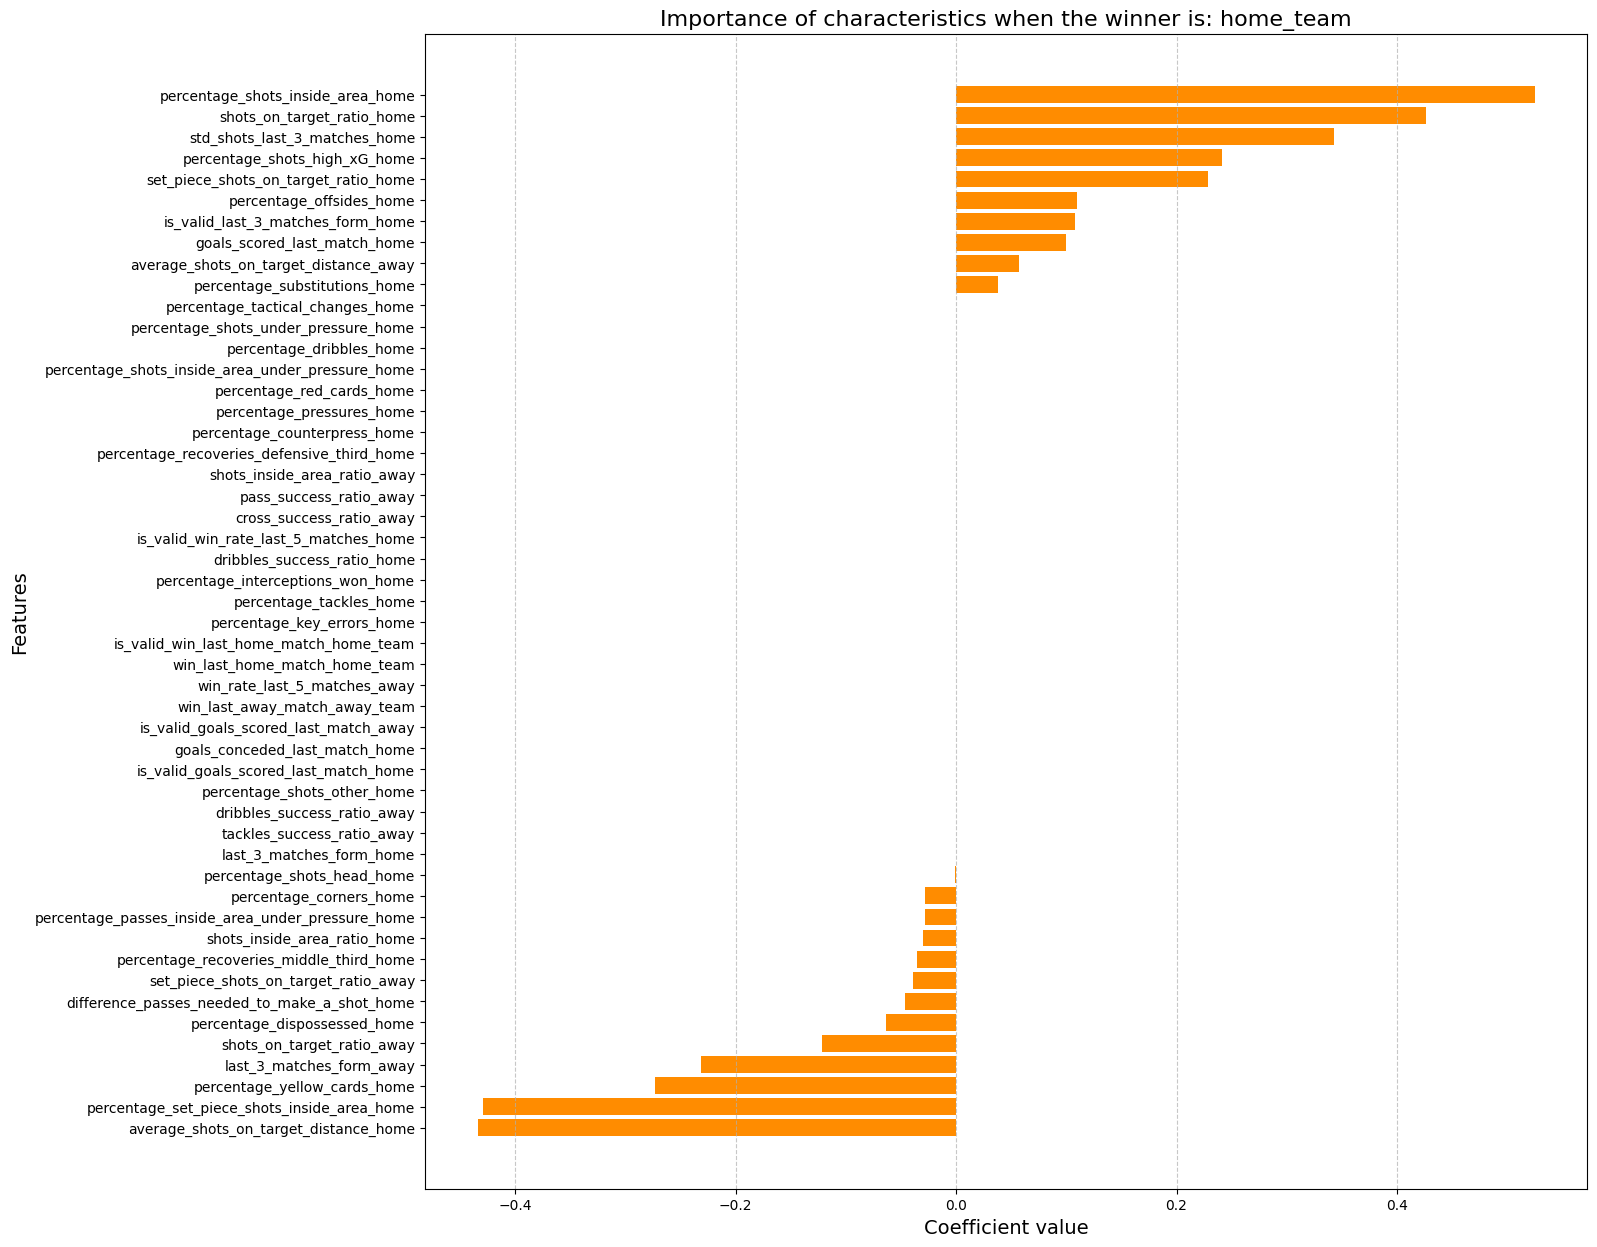

In [12]:
from src.analysis import laliga_global_analysis

laliga_global_analysis(best_model_LaLiga, feature_names_reduced_LaLiga, encoder_LaLiga)

Vamos a analizar cada uno de estos gr치ficos:
- **Importancia de caracter칤sticas para la victoria del equipo visitante (*away_team*)**: En este gr치fico, observamos las caracter칤sticas que m치s influyen en que el equipo visitante gane el partido. Algunas observaciones clave:
    - 游늳 Caracter칤sticas que favorecen la victoria del equipo visitante (coeficientes positivos):
        - Diferencia de pases necesarios para hacer un gol (difference_passes_needed_to_make_a_shot_home): Si el equipo local necesita m치s pases para generar un gol, esto indica una menor eficiencia ofensiva, lo que favorece al equipo visitante.
        - Ratio de tiros a puerta del equipo visitante (shots_on_target_ratio_away): Cuanto mayor sea este valor, m치s eficiente es el equipo visitante al finalizar sus jugadas.
        - Tiros de cabeza del equipo visitante (shots_head_home): Si el equipo local intenta m치s tiros de cabeza, puede reflejar una dependencia de centros y juego a칠reo, lo que podr칤a ser una se침al de que tienen menos oportunidades claras de gol.
    - 游늴 Caracter칤sticas que disminuyen la probabilidad de victoria del equipo visitante (coeficientes negativos):
        - Tiros de alto xG del equipo local (percentage_shots_high_xG_home): Si el equipo local genera m치s tiros de alto valor de gol esperado (xG), es m치s probable que marquen y ganen el partido.
        - Ratio de tiros a puerta del equipo local (shots_on_target_ratio_home): Un equipo local m치s preciso en sus disparos es menos propenso a perder.
        - N칰mero de fueras de juego del equipo local (percentage_offsides_home): Puede indicar una estrategia ofensiva m치s agresiva, lo que reduce la posibilidad de que el equipo visitante gane.
    - 游닇 Conclusi칩n: Para que el equipo visitante gane, es crucial que finalicen mejor sus jugadas y que el equipo local tenga dificultades ofensivas, como necesitar m치s pases para generar un gol o depender de tiros de cabeza.

- **Importancia de caracter칤sticas para el empate (*draw*)**: El empate en un partido suele estar influenciado por un equilibrio en las m칠tricas de ataque y defensa de ambos equipos. Algunas observaciones clave:
    - 游늳 Caracter칤sticas que favorecen el empate (coeficientes positivos):
        - Cambios t치cticos del equipo local (percentage_tactical_changes_home): Indica que el equipo local ajusta su estrategia durante el partido, lo que puede hacer que el juego sea m치s parejo y termine en empate.
        - N칰mero de recuperaciones en el tercio medio del campo (percentage_recoveries_middle_third_home): Un alto n칰mero de recuperaciones en el mediocampo sugiere un partido con muchas disputas y menos oportunidades claras de gol.
        - Presi칩n y contragolpe del equipo local (percentage_counterpress_home): Un equipo local que presiona mucho despu칠s de perder el bal칩n puede neutralizar los ataques del visitante, resultando en un empate.
    - 游늴 Caracter칤sticas que reducen la probabilidad de empate (coeficientes negativos):
        - Precisi칩n en los pases del equipo visitante (pass_success_ratio_away): Si el equipo visitante es preciso en sus pases, aumenta la probabilidad de que puedan generar m치s ocasiones de gol y ganar el partido.
        - Tiros dentro del 치rea del equipo visitante (shots_inside_area_ratio_away): Cuantas m치s llegadas claras tenga el equipo visitante, menos probable es que el partido termine en empate.
        - Ratio de tiros a puerta del equipo visitante (shots_on_target_ratio_away): Una mayor eficiencia del visitante en tiros a puerta reduce la probabilidad de empate.
    - 游닇 Conclusi칩n: El empate suele ocurrir cuando ambos equipos tienen un estilo equilibrado, con una buena presi칩n en el mediocampo y ajustes t치cticos, pero sin una gran diferencia en precisi칩n de pases o tiros dentro del 치rea.

- **Importancia de caracter칤sticas para la victoria del equipo local (*local_team*)**: Este gr치fico muestra las caracter칤sticas que aumentan o disminuyen la probabilidad de que el equipo local gane el partido. Algunas observaciones claves:
    - 游늳 Caracter칤sticas que favorecen la victoria del equipo local (coeficientes positivos):
        - Porcentaje de tiros dentro del 치rea del equipo local (percentage_shots_inside_area_home): Los equipos locales que generan m치s tiros dentro del 치rea tienen m치s probabilidades de marcar y ganar.
        - Ratio de tiros a puerta del equipo local (shots_on_target_ratio_home): Un equipo local m치s preciso en sus disparos tiene mayor probabilidad de victoria.
        - N칰mero de tiros con alto xG del equipo local (shots_high_xG_home): Si el equipo local genera m치s tiros con alto valor de gol esperado (xG), es m치s probable que marquen y ganen el partido.
    - 游늴 Caracter칤sticas que disminuyen la probabilidad de victoria del equipo local (coeficientes negativos):
        - Diferencia de pases necesarios para hacer un gol (difference_passes_needed_to_make_a_shot_home): Si el equipo local necesita muchos pases para generar un gol, significa que su ofensiva es menos eficiente.
        - Precisi칩n en los centros al 치rea del equipo visitante (cross_success_ratio_away): Un equipo visitante que logre conectar bien sus centros tiene m치s probabilidades de generar peligro y evitar la victoria local.
        - Ratio de 칠xito en dribbles del equipo visitante (dribbles_success_ratio_away): Si el equipo visitante es h치bil en el regate, puede desestabilizar la defensa local y reducir sus opciones de victoria.
    - 游닇 Conclusi칩n: Para que el equipo local gane, es clave que generen tiros dentro del 치rea con buena precisi칩n, mientras que la presencia de un equipo visitante con buena precisi칩n en pases y regates reduce las probabilidades de victoria local. 

- **Conclusiones generales**: 
    - El equipo visitante gana cuando tiene alta precisi칩n en sus tiros a puerta y el equipo local es ineficiente ofensivamente.
    - El empate ocurre en partidos con alta presi칩n en el mediocampo y cambios t치cticos, lo que equilibra el juego.
    - El equipo local gana cuando genera muchas oportunidades de gol dentro del 치rea y tiene buena precisi칩n en sus tiros.

Ahora comenzamos el an치lisis de explicabilidad utilizando SHAP.

In [13]:
explainer_LaLiga = shap.Explainer(best_model_LaLiga, X_train_reduced_LaLiga, feature_names=feature_names_reduced_LaLiga)
shap_values_LaLiga = explainer_LaLiga(X_test_reduced_LaLiga)

Clase 0: ['away_team']
Caracter칤sticas importantes (27):
['shots_on_target_ratio_home', 'shots_on_target_ratio_away', 'average_shots_on_target_distance_home', 'shots_inside_area_ratio_away', 'pass_success_ratio_away', 'cross_success_ratio_away', 'dribbles_success_ratio_home', 'set_piece_shots_on_target_ratio_away', 'is_valid_win_rate_last_5_matches_home', 'win_last_home_match_home_team', 'win_last_away_match_away_team', 'goals_scored_last_match_home', 'is_valid_goals_scored_last_match_home', 'is_valid_goals_scored_last_match_away', 'percentage_shots_high_xG_home', 'percentage_shots_head_home', 'percentage_shots_other_home', 'difference_passes_needed_to_make_a_shot_home', 'percentage_corners_home', 'percentage_tackles_home', 'percentage_key_errors_home', 'percentage_red_cards_home', 'percentage_counterpress_home', 'percentage_offsides_home', 'percentage_shots_under_pressure_home', 'percentage_passes_inside_area_under_pressure_home', 'percentage_substitutions_home']
Caracter칤sticas SIN i

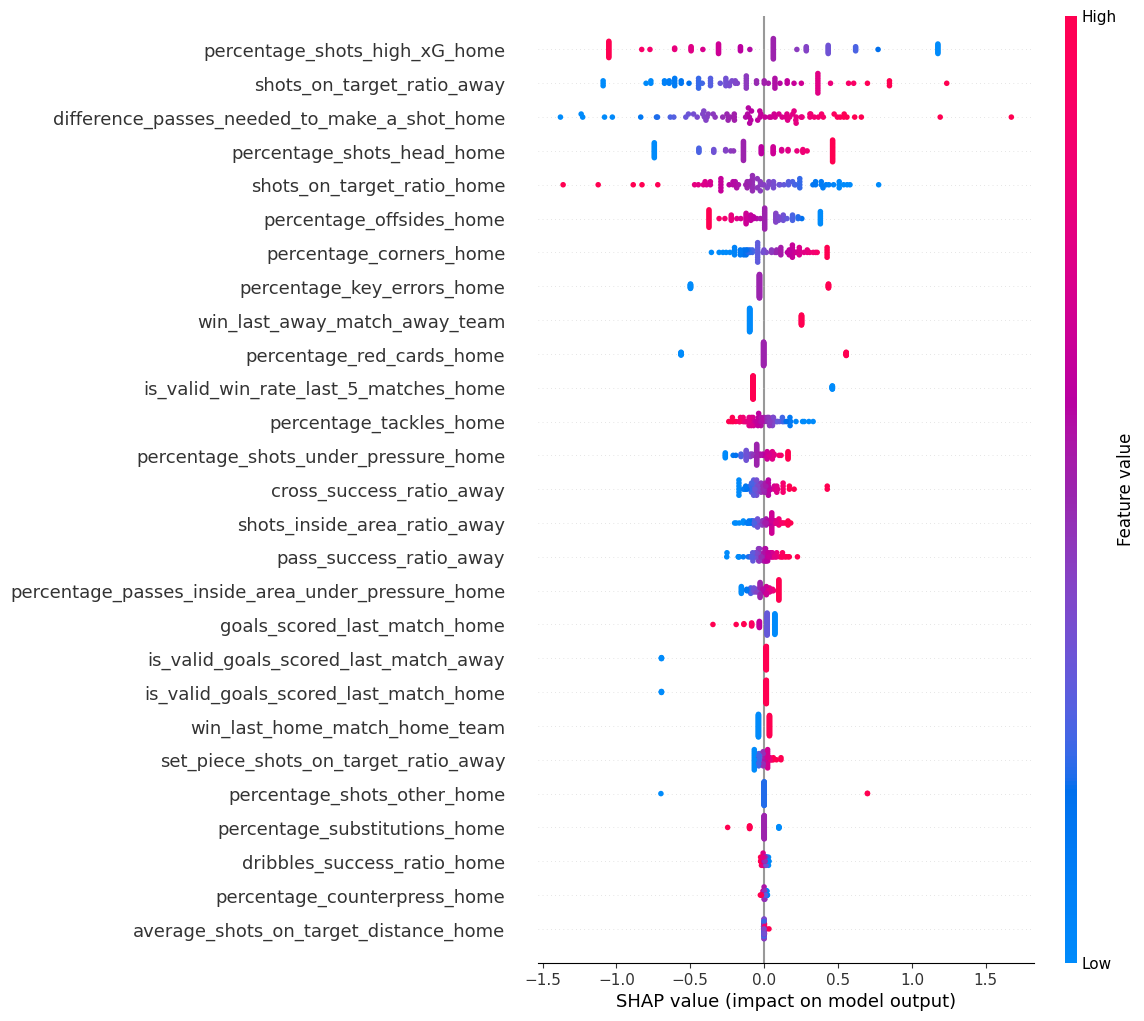

Clase 1: ['draw']
Caracter칤sticas importantes (15):
['pass_success_ratio_away', 'cross_success_ratio_away', 'dribbles_success_ratio_away', 'set_piece_shots_on_target_ratio_home', 'last_3_matches_form_away', 'win_last_away_match_away_team', 'is_valid_goals_scored_last_match_home', 'is_valid_goals_scored_last_match_away', 'std_shots_last_3_matches_home', 'percentage_shots_other_home', 'percentage_counterpress_home', 'percentage_recoveries_middle_third_home', 'percentage_recoveries_defensive_third_home', 'percentage_shots_inside_area_under_pressure_home', 'percentage_tactical_changes_home']
Caracter칤sticas SIN impacto (35):
['shots_on_target_ratio_home', 'shots_on_target_ratio_away', 'average_shots_on_target_distance_home', 'average_shots_on_target_distance_away', 'shots_inside_area_ratio_home', 'shots_inside_area_ratio_away', 'tackles_success_ratio_away', 'dribbles_success_ratio_home', 'set_piece_shots_on_target_ratio_away', 'last_3_matches_form_home', 'is_valid_last_3_matches_form_home'

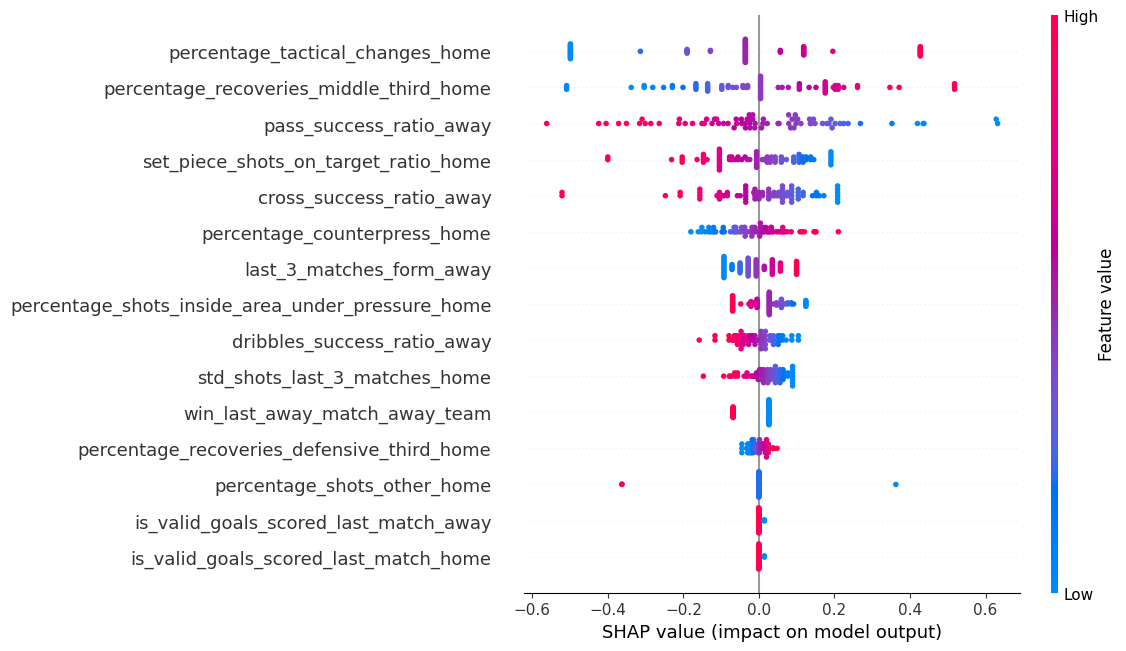

Clase 2: ['home_team']
Caracter칤sticas importantes (23):
['shots_on_target_ratio_home', 'shots_on_target_ratio_away', 'average_shots_on_target_distance_home', 'average_shots_on_target_distance_away', 'shots_inside_area_ratio_home', 'set_piece_shots_on_target_ratio_home', 'set_piece_shots_on_target_ratio_away', 'is_valid_last_3_matches_form_home', 'last_3_matches_form_away', 'goals_scored_last_match_home', 'std_shots_last_3_matches_home', 'percentage_shots_high_xG_home', 'percentage_shots_inside_area_home', 'percentage_shots_head_home', 'difference_passes_needed_to_make_a_shot_home', 'percentage_corners_home', 'percentage_yellow_cards_home', 'percentage_offsides_home', 'percentage_dispossessed_home', 'percentage_recoveries_middle_third_home', 'percentage_passes_inside_area_under_pressure_home', 'percentage_set_piece_shots_inside_area_home', 'percentage_substitutions_home']
Caracter칤sticas SIN impacto (27):
['shots_inside_area_ratio_away', 'pass_success_ratio_away', 'cross_success_ratio_

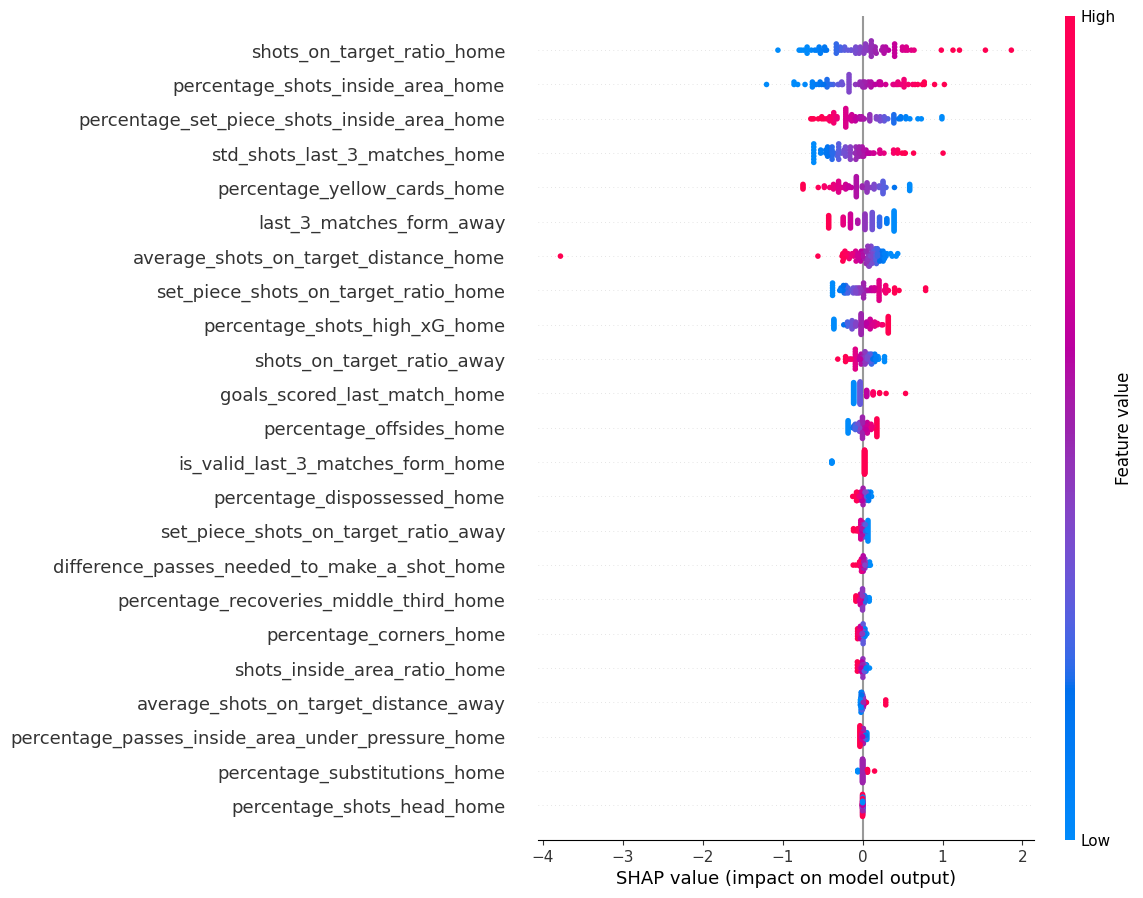

In [14]:
# definimos un umbral de importancia
threshold = 0.0

for i in range(shap_values_LaLiga.shape[2]):
    print(f"Clase {i}: {encoder_LaLiga.inverse_transform([i])}")
    # calculamos la importancia media de cada caracter칤stica y filtramos las caracter칤sticas que superen el umbral
    shap_importance = np.abs(shap_values_LaLiga.values[:, :, i]).mean(axis=0)
    important_features = np.where(shap_importance > threshold)[0]
    unimportant_features = np.where(shap_importance <= threshold)[0]
    print(f"Caracter칤sticas importantes ({len(important_features)}):")
    print([feature_names_reduced_LaLiga[idx] for idx in important_features])
    print(f"Caracter칤sticas SIN impacto ({len(unimportant_features)}):")
    print([feature_names_reduced_LaLiga[idx] for idx in unimportant_features])
    # si hay caracter칤sticas que superen el umbral, mostramos el gr치fico
    if len(important_features) > 0:
        shap.plots.beeswarm(shap_values_LaLiga[:, important_features, i], max_display=important_features.size)
    else:
        print(f"No hay caracter칤sticas con impacto mayor a {threshold} para la clase {i}.")